In [1]:
from tqdm import tqdm
import os
import time
from datetime import datetime
from random import randint

import numpy as np
from scipy import stats
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import KFold

import nibabel as nib

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.animation as anim
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

import seaborn as sns
from skimage.transform import resize
from skimage.util import montage

from IPython.display import Image as show_gif
from IPython.display import clear_output

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

import re
import warnings


warnings.simplefilter("ignore")


In [9]:
from utils.Meter import Meter, DiceLoss, BCEDiceLoss, dice_coef_metric_per_classes, jaccard_coef_metric_per_classes

# CAN POTENTIALLY TRY DIFFERENT AUGMENTATION TECHNIQUES HERE
from utils.BratsDataset import BratsDataset

from utils.Meter import BCEDiceLoss

from models.UNet3d import UNet3d
from models.UNet3dSingleConv import UNet3dSingleConv
from models.UNet3dDropout import UNet3dDropout
from models.SwinUNETR import SwinUNETR
from models.UNet3d_your_modifications import UNet3d_your_modifications
from models.UNet3d_SELU import UNet3d_SELU
from models.UNet3d_atten import UNet3d_atten
from models.ONet3d import ONet3d
from models.ONet3d_v2 import ONet3d_v2
from models.ONet3d_v3 import ONet3d_v3
from models.ONet3d_v3_DoubleConv import ONet3d_v3_DoubleConv
from models.UNet3d_GELU import UNet3d_GELU
from models.ONet3d_v3_GELU import ONet3d_v3_GELU
from models.SphereNet3d import SphereNet3d
from models.SphereNet3d import SphereNet3d
# from models.SphereNet3d_GELU import SphereNet3d_GELU


In [48]:
def get_dataloaders(
    dataset: torch.utils.data.Dataset,
    path_to_csv: str,
    # phase: str,
    val_fold: int = 0,  # Choose which fold to be the validation fold
    test_fold: int = 1,
    batch_size: int = 1,
    num_workers: int = 4,
    do_resizing: bool = True,
):
    assert (val_fold != test_fold)

    df = pd.read_csv(path_to_csv)

    '''Returns: dataloader for the model training'''
    # Data in folds other than 0 are used for training
    train_df = df.loc[~df['fold'].isin(
        [val_fold, test_fold])].reset_index(drop=True)
    # Data in fold 0 is used for validation
    val_df = df.loc[df['fold'] == val_fold].reset_index(drop=True)
    test_df = df.loc[df['fold'] == test_fold].reset_index(drop=True)

    # dataset = dataset(df, phase)
    train_dataset = dataset(train_df, "train", do_resizing=do_resizing)
    val_dataset = dataset(val_df, "val", do_resizing=do_resizing)
    test_dataset = dataset(test_df, "test", do_resizing=do_resizing)
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=True,
    )
    val_dataloader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=True,
    )
    test_dataloader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=True,
    )
    return train_dataloader, val_dataloader, test_dataloader


In [46]:
modelDict = {
    "3DOnet_DoubleConv_Kernel1": ONet3d_v3_DoubleConv(in_channels=4, n_classes=3, n_channels=24).to('cuda'),
    "3DOnet_SingleConv_Kernel1": ONet3d_v3(in_channels=4, n_classes=3, n_channels=24).to('cuda'),
    "3DOnet_SingleConv_Kernel1_32_Channels": ONet3d_v3(in_channels=4, n_classes=3, n_channels=32).to('cuda'),
    "3DOnet_SingleConv_Kernel1_GELU": ONet3d_v3_GELU(in_channels=4, n_classes=3, n_channels=24).to('cuda'),
    "3DOnet_SingleConv_Kernel1_GELU_AdamW": ONet3d_v3_GELU(in_channels=4, n_classes=3, n_channels=24).to('cuda'),
    "3DOnet_SingleConv_Kernel3": ONet3d_v2(in_channels=4, n_classes=3, n_channels=24).to('cuda'),
    "3DOnet_SingleConv_Kernel5": ONet3d(in_channels=4, n_classes=3, n_channels=24).to('cuda'),
    "3DUnet": UNet3d(in_channels=4, n_classes=3, n_channels=24).to('cuda'),
    "3DUnet_32_Channels": UNet3d(in_channels=4, n_classes=3, n_channels=32).to('cuda'),
    "3DUnet_Atten": UNet3d_atten(in_channels=4, n_classes=3, n_channels=24).to('cuda'),
    "3DUnet_Dropout": UNet3dDropout(in_channels=4, n_classes=3, n_channels=24).to('cuda'),
    "3DUnet_GELU": UNet3d_GELU(in_channels=4, n_classes=3, n_channels=24).to('cuda'),
    "3DUnet_SELU": UNet3d_SELU(in_channels=4, n_classes=3, n_channels=24).to('cuda'),
    "3DUnet_SingleConv": UNet3dSingleConv(in_channels=4, n_classes=3, n_channels=24).to('cuda'),
    "SphereNet3D": SphereNet3d(in_channels=4, n_classes=3, n_channels=16).to('cuda'),
    "SwinUNETR": SwinUNETR(in_channels=4, out_channels=3, img_size=(128, 224, 224), depths=(1, 1, 1, 1), num_heads=(2, 4, 8, 16)).to('cuda'),
    "SwinUNETR_AdamW": SwinUNETR(in_channels=4, out_channels=3, img_size=(128, 224, 224), depths=(1, 1, 1, 1), num_heads=(2, 4, 8, 16)).to('cuda'),
    "SwinUNETR_DoubleLayerDepth": SwinUNETR(in_channels=4, out_channels=3, img_size=(128, 224, 224), depths=(2, 2, 2, 2), num_heads=(2, 4, 8, 16)).to('cuda'),
  }

In [112]:
def compute_scores_per_classes(model,
                               dataloader,
                               classes):
    """
    Compute Dice and Jaccard coefficients for each class.
    Params:
        model: neural net for make predictions.
        dataloader: dataset object to load data from.
        classes: list with classes.
        Returns: dictionaries with dice and jaccard coefficients for each class for each slice.
    """
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    dice_scores_per_classes = {key: list() for key in classes}
    iou_scores_per_classes = {key: list() for key in classes}
    ids = {"Ids":list()}

    with torch.no_grad():
        for i, data in enumerate(dataloader):
            imgs, targets = data['image'], data['mask']
            imgs, targets = imgs.to(device), targets.to(device)
            logits = model(imgs)
            logits = logits.detach().cpu().numpy()
            targets = targets.detach().cpu().numpy()

            dice_scores = dice_coef_metric_per_classes(logits, targets)
            iou_scores = jaccard_coef_metric_per_classes(logits, targets)
            ids["Ids"].extend(data["Id"])

            for key in dice_scores.keys():
                dice_scores_per_classes[key].extend(dice_scores[key])

            for key in iou_scores.keys():
                iou_scores_per_classes[key].extend(iou_scores[key])
    return dice_scores_per_classes, iou_scores_per_classes, ids


In [113]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
  
def evaluate_all(chkpt_type="best", results_dict = {}):
  chkpt_prefix = "your_best_model" if chkpt_type == "best" else "your_last_epoch_model"
  for dirname in os.listdir("Logs"):
    start = datetime.now()
    model_name = dirname
    model = modelDict[model_name]
    results_dict[model_name] = {}
    
    checkpoint_path = None
    
    for filename in os.listdir(f"Logs/{dirname}"):
      if chkpt_prefix in filename:
        checkpoint_path = f"Logs/{dirname}/{filename}"
        break
    
    try:
      model.load_state_dict(torch.load(
          checkpoint_path, map_location='cpu'))
      model.eval()
      print(f"{model_name} loaded with chkpt: {checkpoint_path}. parameters: {count_parameters(model)}")
    except Exception as e:
      print(f"Error loading {model_name} with chkpt: {checkpoint_path}. parameters: {count_parameters(model)}")
      print(e)
      
    _, _, test_dataloader = get_dataloaders(
        dataset=BratsDataset, path_to_csv="./fold_data.csv", val_fold=0, test_fold=1, batch_size=1, do_resizing=True)
    
    dice_scores_per_classes, iou_scores_per_classes, ids = compute_scores_per_classes(
        model, test_dataloader, ['WT', 'TC', 'ET']
    )
    ids_df = pd.DataFrame(ids)
    ids_df.columns = ['Ids']
    
    dice_df = pd.DataFrame(dice_scores_per_classes)


    dice_df.columns = ['WT dice', 'TC dice', 'ET dice']

    iou_df = pd.DataFrame(iou_scores_per_classes)
    iou_df.columns = ['WT jaccard', 'TC jaccard', 'ET jaccard']
    val_metics_df = pd.concat([ids_df, dice_df, iou_df], axis=1, sort=True)
    val_metics_df = val_metics_df.loc[:, ['Ids',
                                          'WT dice', 'WT jaccard',
                                          'TC dice', 'TC jaccard',
                                          'ET dice', 'ET jaccard']]
    mean_metrics_df = val_metics_df.mean()
    val_metics_df.sort_values(by=["Ids"], inplace=True)
    val_metics_df = val_metics_df.reset_index(drop=True)
    results_dict[model_name]["val_metics_df"] = val_metics_df
    results_dict[model_name]["WT dice"] = mean_metrics_df["WT dice"]
    results_dict[model_name]["WT jaccard"] = mean_metrics_df["WT jaccard"]
    results_dict[model_name]["TC dice"] = mean_metrics_df["TC dice"]
    results_dict[model_name]["TC jaccard"] = mean_metrics_df["TC jaccard"]
    results_dict[model_name]["ET dice"] = mean_metrics_df["ET dice"]
    results_dict[model_name]["ET jaccard"] = mean_metrics_df["ET jaccard"]
    inference_time = datetime.now() - start
    results_dict[model_name]["Inference time"] = inference_time
    
    del model
  return results_dict





In [114]:
results_dict_last_epoch = evaluate_all(chkpt_type="last")


3DOnet_SingleConv_Kernel1_32_Channels loaded with chkpt: Logs/3DOnet_SingleConv_Kernel1_32_Channels/your_last_epoch_model_20230314-222549.pth. parameters: 5597571
SphereNet3D loaded with chkpt: Logs/SphereNet3D/your_last_epoch_model_20230319-011358.pth. parameters: 6134019
3DUnet_SingleConv loaded with chkpt: Logs/3DUnet_SingleConv/your_last_epoch_model_20230322-164951.pth. parameters: 3006507
3DOnet_SingleConv_Kernel1_GELU_AdamW loaded with chkpt: Logs/3DOnet_SingleConv_Kernel1_GELU_AdamW/your_last_epoch_model_20230317-195004.pth. parameters: 3150435
SwinUNETR_AdamW loaded with chkpt: Logs/SwinUNETR_AdamW/your_last_epoch_model_20230311-072307.pth. parameters: 14981601
3DUnet_Atten loaded with chkpt: Logs/3DUnet_Atten/your_last_epoch_model_20230311-222850.pth. parameters: 6094231
3DOnet_SingleConv_Kernel1 loaded with chkpt: Logs/3DOnet_SingleConv_Kernel1/your_last_epoch_model_20230313-220534.pth. parameters: 3150435
SwinUNETR loaded with chkpt: Logs/SwinUNETR/your_last_epoch_model_2023

In [115]:
results_dict_best_epoch = evaluate_all(chkpt_type="best")


3DOnet_SingleConv_Kernel1_32_Channels loaded with chkpt: Logs/3DOnet_SingleConv_Kernel1_32_Channels/your_best_model_20230314-193438.pth. parameters: 5597571
SphereNet3D loaded with chkpt: Logs/SphereNet3D/your_best_model_20230318-234612.pth. parameters: 6134019
3DUnet_SingleConv loaded with chkpt: Logs/3DUnet_SingleConv/your_best_model_20230322-164448.pth. parameters: 3006507
3DOnet_SingleConv_Kernel1_GELU_AdamW loaded with chkpt: Logs/3DOnet_SingleConv_Kernel1_GELU_AdamW/your_best_model_20230317-181323.pth. parameters: 3150435
SwinUNETR_AdamW loaded with chkpt: Logs/SwinUNETR_AdamW/your_best_model_20230311-061544.pth. parameters: 14981601
3DUnet_Atten loaded with chkpt: Logs/3DUnet_Atten/your_best_model_20230311-221951.pth. parameters: 6094231
3DOnet_SingleConv_Kernel1 loaded with chkpt: Logs/3DOnet_SingleConv_Kernel1/your_best_model_20230313-204822.pth. parameters: 3150435
SwinUNETR loaded with chkpt: Logs/SwinUNETR/your_best_model_20230310-230442.pth. parameters: 14981601
3DOnet_Dou

In [131]:
with open("results/results_last_epoch.txt", "w") as outfile:
    outfile.write(str(results_dict_last_epoch))
    
with open("results/results_best_epoch.txt", "w") as outfile:
    outfile.write(str(results_dict_best_epoch))


In [191]:
results_dict_last_epoch_trunc = results_dict_last_epoch.copy()
for k in results_dict_last_epoch_trunc:
  del results_dict_last_epoch_trunc[k]["val_metics_df"]
results_dict_last_epoch_trunc


{'3DOnet_SingleConv_Kernel1_32_Channels': {'WT dice': 0.8859685722222216,
  'WT jaccard': 0.8084778088011756,
  'TC dice': 0.7365154700320921,
  'TC jaccard': 0.6299864930473023,
  'ET dice': 0.6705782045593719,
  'ET jaccard': 0.5760742256474678,
  'Inference time': datetime.timedelta(seconds=31, microseconds=138757)},
 'SphereNet3D': {'WT dice': 0.8666824196638818,
  'WT jaccard': 0.7929235839543941,
  'TC dice': 0.7526103281071324,
  'TC jaccard': 0.6581906067810749,
  'ET dice': 0.6860080553346143,
  'ET jaccard': 0.593017684781998,
  'Inference time': datetime.timedelta(seconds=38, microseconds=618847)},
 '3DUnet_SingleConv': {'WT dice': 0.8730757200440719,
  'WT jaccard': 0.7900710768850159,
  'TC dice': 0.6820014661860567,
  'TC jaccard': 0.5785338361220659,
  'ET dice': 0.6245684303206838,
  'ET jaccard': 0.5209983689555212,
  'Inference time': datetime.timedelta(seconds=16, microseconds=355273)},
 '3DOnet_SingleConv_Kernel1_GELU_AdamW': {'WT dice': 0.8879399952479143,
  'WT ja

In [301]:
with open("results/results_last_epoch.txt", "w") as outfile:
    outfile.write(str(results_dict_last_epoch))

with open("results/results_best_epoch.txt", "w") as outfile:
    outfile.write(str(results_dict_best_epoch))


In [133]:
for k in results_dict_last_epoch:
  print(k, results_dict_last_epoch[k]["Inference time"])


3DOnet_SingleConv_Kernel1_32_Channels 0:00:31.138757
SphereNet3D 0:00:38.618847
3DUnet_SingleConv 0:00:16.355273
3DOnet_SingleConv_Kernel1_GELU_AdamW 0:00:24.342455
SwinUNETR_AdamW 0:00:21.838608
3DUnet_Atten 0:00:20.770115
3DOnet_SingleConv_Kernel1 0:00:23.725691
SwinUNETR 0:00:21.373539
3DOnet_DoubleConv_Kernel1 0:00:28.323277
3DUnet_Dropout 0:00:18.837509
3DUnet_SELU 0:00:18.982965
3DUnet 0:00:20.286731
3DUnet_32_Channels 0:00:23.384004
3DOnet_SingleConv_Kernel1_GELU 0:00:23.777033
SwinUNETR_DoubleLayerDepth 0:00:24.915094
3DUnet_GELU 0:00:18.849437
3DOnet_SingleConv_Kernel5 0:00:34.315344
3DOnet_SingleConv_Kernel3 0:00:26.703524


In [136]:
for k in results_dict_last_epoch:
  print(results_dict_last_epoch[k]["Inference time"])


0:00:31.138757
0:00:38.618847
0:00:16.355273
0:00:24.342455
0:00:21.838608
0:00:20.770115
0:00:23.725691
0:00:21.373539
0:00:28.323277
0:00:18.837509
0:00:18.982965
0:00:20.286731
0:00:23.384004
0:00:23.777033
0:00:24.915094
0:00:18.849437
0:00:34.315344
0:00:26.703524


In [139]:
def get_losses(filename):

  # open the text file
  with open(filename, 'r') as f:
      contents = f.read()

  # extract the train losses and val losses using regular expressions
  train_losses_str = re.search(
      r"losses:{'train': (.+?), 'val'", contents).group(1)
  val_losses_str = re.search(r"'val': \[(.+?)\}", contents).group(1)

  train_losses_str = train_losses_str.replace('[', '').replace(']', '')
  val_losses_str = val_losses_str.replace('[', '').replace(']', '')

  # convert the strings to lists of floating-point numbers
  train_losses = [float(x.strip()) for x in train_losses_str.split(', ')]
  val_losses = [float(x.strip()) for x in val_losses_str.split(', ')]

  print(f"{len(train_losses)} train and {len(val_losses)} val losses found in {filename}")

  # print the lists
  return train_losses, val_losses


def get_param_count(filename):

  # open the text file
  with open(filename, 'r') as f:
      contents = f.read()

  # extract the param count using regular expressions
  param_str = re.search(
      r"(?<=parameter_count:).*", contents).group(0)
  param_count = int(param_str)
  print(f"Parameter count = {param_count} in {filename}")

  return param_count


def get_dice_scores(filename):

  # open the text file
  with open(filename, 'r') as f:
      lines = f.readlines()

  for line in lines:
    if "dice_scores" in line:

      # extract the dice scores and iou scores using regular expressions
      train_dice_str = re.search(
          r"'train': (.+?), 'val'", line).group(1)
      val_dice_str = re.search(r"'val': \[(.+?)\}", line).group(1)

      train_dice_str = train_dice_str.replace('[', '').replace(']', '')
      val_dice_str = val_dice_str.replace('[', '').replace(']', '')

      # convert the strings to lists of floating-point numbers
      train_dice = [float(x.strip()) for x in train_dice_str.split(', ')]
      val_dice = [float(x.strip()) for x in val_dice_str.split(', ')]
      break
  print(f"{len(train_dice)} train and {len(val_dice)} val dice score found in {filename}")
  return train_dice, val_dice


def get_jaccard_scores(filename):

  # open the text file
  with open(filename, 'r') as f:
      lines = f.readlines()

  for line in lines:
    if "jaccard_scores" in line:

      # extract the dice scores and iou scores using regular expressions
      train_jaccard_str = re.search(
          r"'train': (.+?), 'val'", line).group(1)
      val_jaccard_str = re.search(r"'val': \[(.+?)\}", line).group(1)

      train_jaccard_str = train_jaccard_str.replace('[', '').replace(']', '')
      val_jaccard_str = val_jaccard_str.replace('[', '').replace(']', '')

      # convert the strings to lists of floating-point numbers
      train_jaccard = [float(x.strip()) for x in train_jaccard_str.split(', ')]
      val_jaccard = [float(x.strip()) for x in val_jaccard_str.split(', ')]
      break
  print(f"{len(train_jaccard)} train and {len(val_jaccard)} val jaccard score found in {filename}")
  return train_jaccard, val_jaccard


def get_train_run_time(filename):

  # open the text file
  with open(filename, 'r') as f:
      contents = f.read()

  # extract the param count using regular expressions
  time_str = re.search(
      r"(?<=last_completed_run_time:).*(?=\n)", contents).group(0)
  time_obj = datetime.strptime(time_str, "%H:%M:%S.%f").time()
  print(f"Trainer runtime = {time_obj} in {filename}")
  return time_obj


FILENAME = "Logs/3DOnet_DoubleConv_Kernel1/trainer_properties.txt"

get_param_count(FILENAME)
get_train_run_time(FILENAME)
get_losses(FILENAME)
get_dice_scores(FILENAME)
get_jaccard_scores(FILENAME)
print("Test done")


Parameter count = 5896515 in Logs/3DOnet_DoubleConv_Kernel1/trainer_properties.txt
Trainer runtime = 05:51:38.640594 in Logs/3DOnet_DoubleConv_Kernel1/trainer_properties.txt
50 train and 50 val losses found in Logs/3DOnet_DoubleConv_Kernel1/trainer_properties.txt
50 train and 50 val dice score found in Logs/3DOnet_DoubleConv_Kernel1/trainer_properties.txt
50 train and 50 val jaccard score found in Logs/3DOnet_DoubleConv_Kernel1/trainer_properties.txt
Test done


In [146]:
results_dict = {}

for dirname in os.listdir("Logs"):
  model_name = dirname
  results_dict[model_name] = {}

  filename = f"Logs/{dirname}/trainer_properties.txt"
  parameter_count = get_param_count(filename)
  trainer_runtime = get_train_run_time(filename)
  train_losses, val_losses = get_losses(filename)
  train_dices, val_dices = get_dice_scores(filename)
  train_jaccards, val_jacards = get_jaccard_scores(filename)
  results_dict[model_name]["parameter_count"] = parameter_count
  results_dict[model_name]["trainer_runtime"] = trainer_runtime
  results_dict[model_name]["train_losses"] = train_losses
  results_dict[model_name]["val_losses"] = val_losses
  results_dict[model_name]["train_dices"] = train_dices
  results_dict[model_name]["val_dices"] = val_dices
  results_dict[model_name]["train_jaccards"] = train_jaccards
  results_dict[model_name]["val_jacards"] = val_jacards


Parameter count = 5597571 in Logs/3DOnet_SingleConv_Kernel1_32_Channels/trainer_properties.txt
Trainer runtime = 12:10:09.814454 in Logs/3DOnet_SingleConv_Kernel1_32_Channels/trainer_properties.txt
50 train and 50 val losses found in Logs/3DOnet_SingleConv_Kernel1_32_Channels/trainer_properties.txt
50 train and 50 val dice score found in Logs/3DOnet_SingleConv_Kernel1_32_Channels/trainer_properties.txt
50 train and 50 val jaccard score found in Logs/3DOnet_SingleConv_Kernel1_32_Channels/trainer_properties.txt
Parameter count = 6134019 in Logs/SphereNet3D/trainer_properties.txt
Trainer runtime = 10:27:29.978756 in Logs/SphereNet3D/trainer_properties.txt
50 train and 50 val losses found in Logs/SphereNet3D/trainer_properties.txt
50 train and 50 val dice score found in Logs/SphereNet3D/trainer_properties.txt
50 train and 50 val jaccard score found in Logs/SphereNet3D/trainer_properties.txt
Parameter count = 3006507 in Logs/3DUnet_SingleConv/trainer_properties.txt
Trainer runtime = 05:34:3

In [147]:
# obtain color palette with shades corresponding to parameter counts

Unet_colors = ["#D8E8FA", "#CCE0F5", "#B2D2F7",
               "#91C2FA", "#69ADF9", "#3E97FA", "#117FFB"]  # blue
# Onet_colors = ["#F9E0ED", "#F9C7E1", "#F9A5D1", "#FB7CBE", "#FC57AC", "#FA2693", "#DE0977"] # pink
Onet_colors = ["#F4E6F7", "#F0CCF9", "#EBABF9",
               "#E483FA", "#DC4AFC", "#CF0CFA", "#9703B8"]  # purple
Swin_colors = ["#D3F3C4", "#A3F47D", "#44C10A"]  # green
spherenet_colors = ["#FC9A03"]  # orange
Unet_dict = {}
Onet_dict = {}
Swin_dict = {}
spherenet_dict = {}
for model_name in results_dict:
    if "Unet" in model_name:
        Unet_dict[model_name] = results_dict[model_name]["parameter_count"]
    elif "Onet" in model_name:
        Onet_dict[model_name] = results_dict[model_name]["parameter_count"]
    elif "Swin" in model_name:
        Swin_dict[model_name] = results_dict[model_name]["parameter_count"]
    else:
        spherenet_dict[model_name] = results_dict[model_name]["parameter_count"]

sorted_Unet_models = sorted(Unet_dict.items(), key=lambda x: x[1])
sorted_Onet_models = sorted(Onet_dict.items(), key=lambda x: x[1])
sorted_Swin_models = sorted(Swin_dict.items(), key=lambda x: x[1])
sorted_spherenet_models = sorted(spherenet_dict.items(), key=lambda x: x[1])

cols = {}
for i in range(len(sorted_Unet_models)):
    cols[sorted_Unet_models[i][0]] = Unet_colors[i]
for i in range(len(sorted_Onet_models)):
    cols[sorted_Onet_models[i][0]] = Onet_colors[i]
for i in range(len(sorted_Swin_models)):
    cols[sorted_Swin_models[i][0]] = Swin_colors[i]
for i in range(len(sorted_spherenet_models)):
    cols[sorted_spherenet_models[i][0]] = spherenet_colors[i]


2023-03-26 14:19:07,024 - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


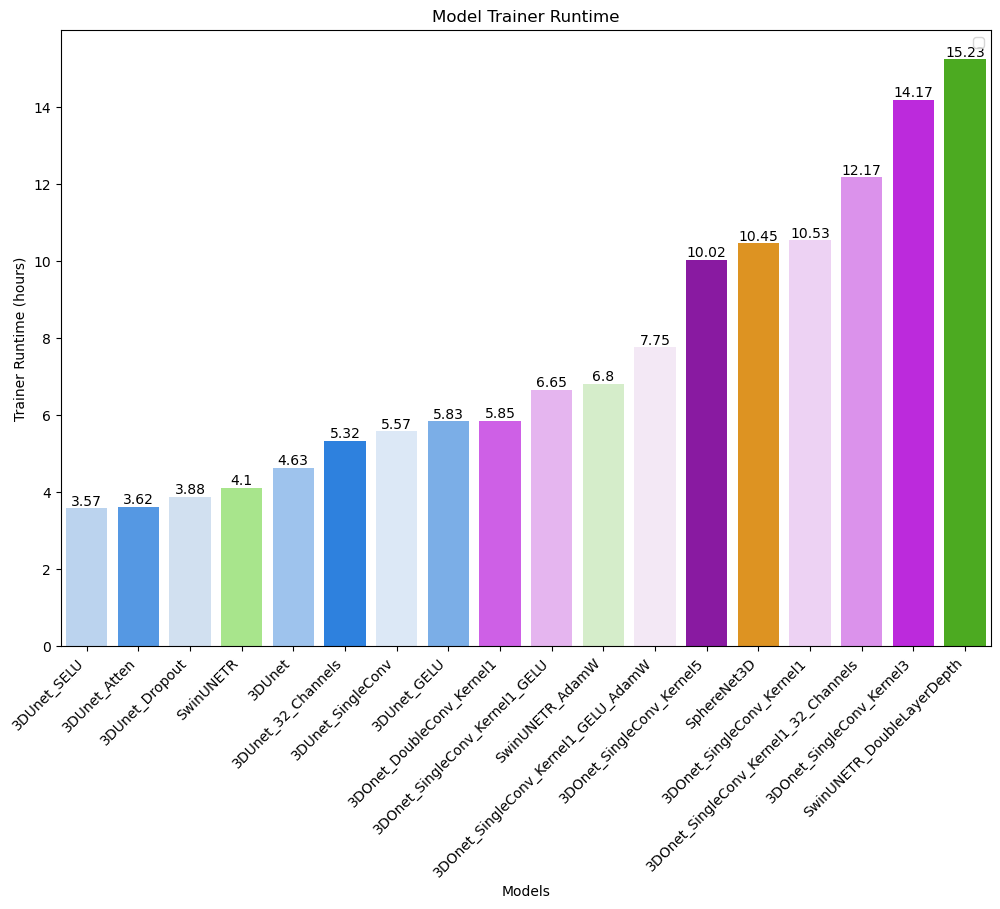

[16.355, 18.838, 18.849, 18.983, 20.287, 20.77, 21.374, 21.839, 23.384, 23.726, 23.777, 24.342, 24.915, 26.704, 28.323, 31.139, 34.315, 38.619]
2023-03-26 14:19:11,930 - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


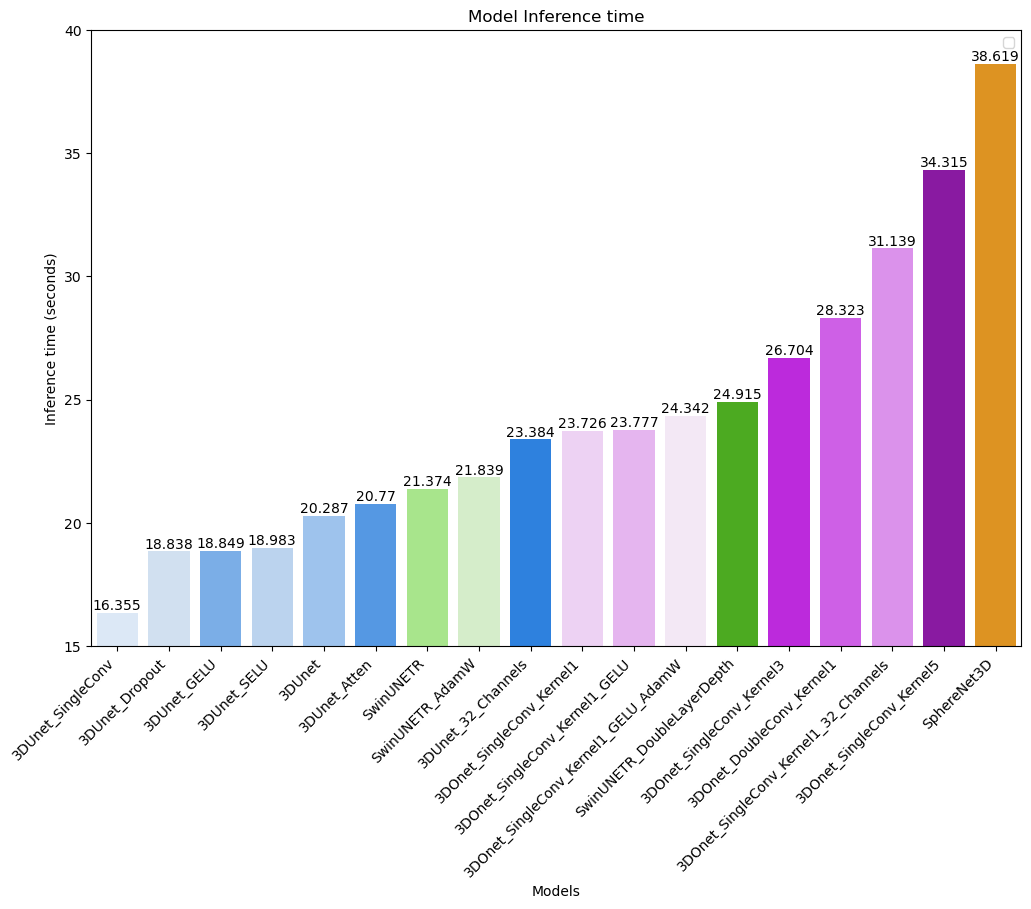

In [298]:


def plot_inference_time():
    inferenceDict = {
        k: results_dict_last_epoch[k]["Inference time"] for k in results_dict_last_epoch}
    # print(inferenceDict)
    x = []
    y = []
    for model_name in inferenceDict:
        x.append(model_name)
        y.append(inferenceDict[model_name])

    # sort based on ascending order of parameter count
    x = [val for _, val in sorted(zip(y, x))]
    y = sorted(y)
    y = [round(i.seconds + i.microseconds*1e-6,3) for i in y]
    # today = datetime.datetime.now()
    # y = [datetime.datetime.combine(today, t) for t in y]
    print(y)
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_title("Model Inference time")

    sns.barplot(x=x, y=y, palette=cols)
    ax.bar_label(ax.containers[0])
    ax.set_xlabel("Models")
    ax.set_ylabel("Inference time (seconds)")
    ax.legend()
    ax.set_ylim(15, 40)
    plt.xticks(rotation=45, ha='right')
    plt.show()


plot_inference_time()


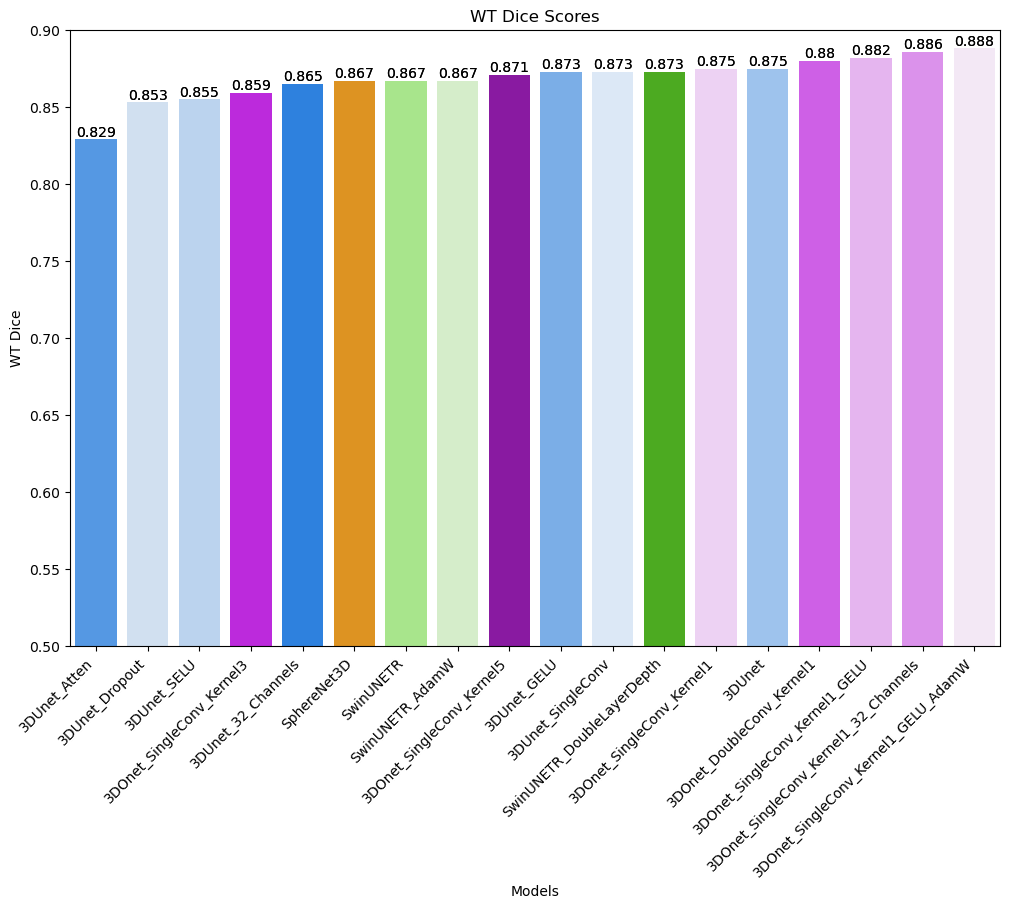

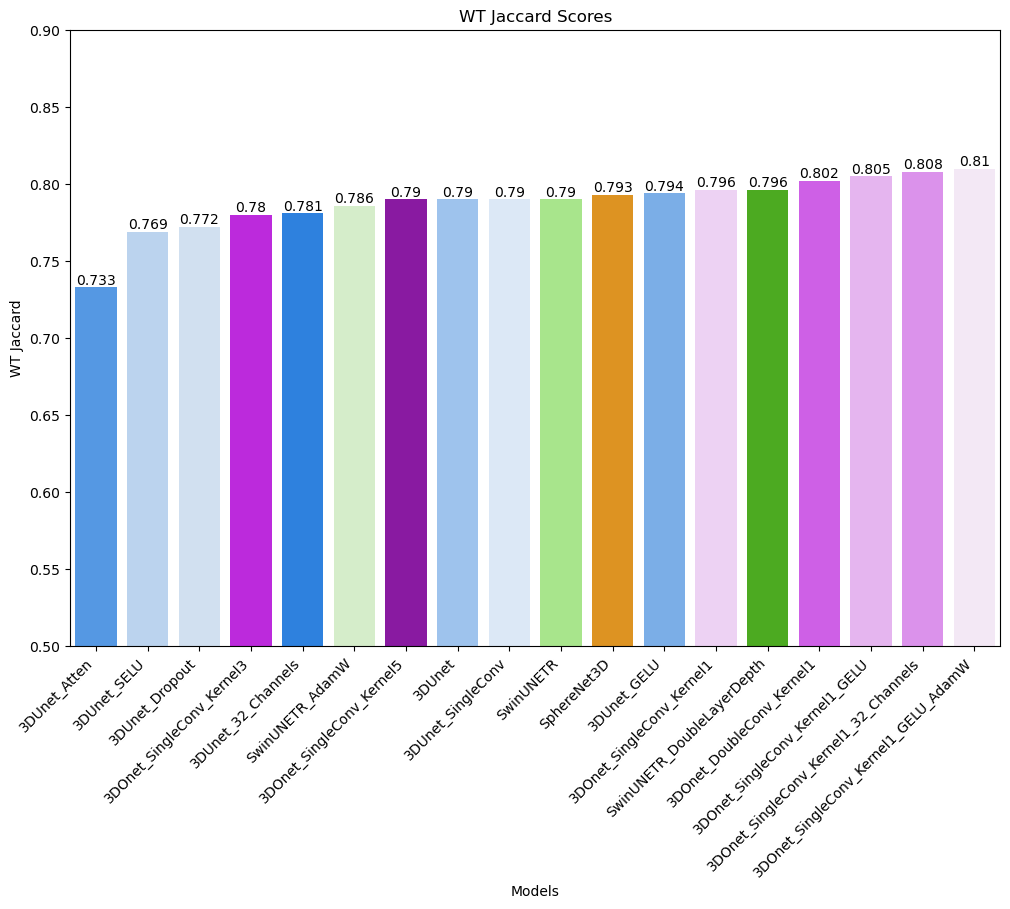

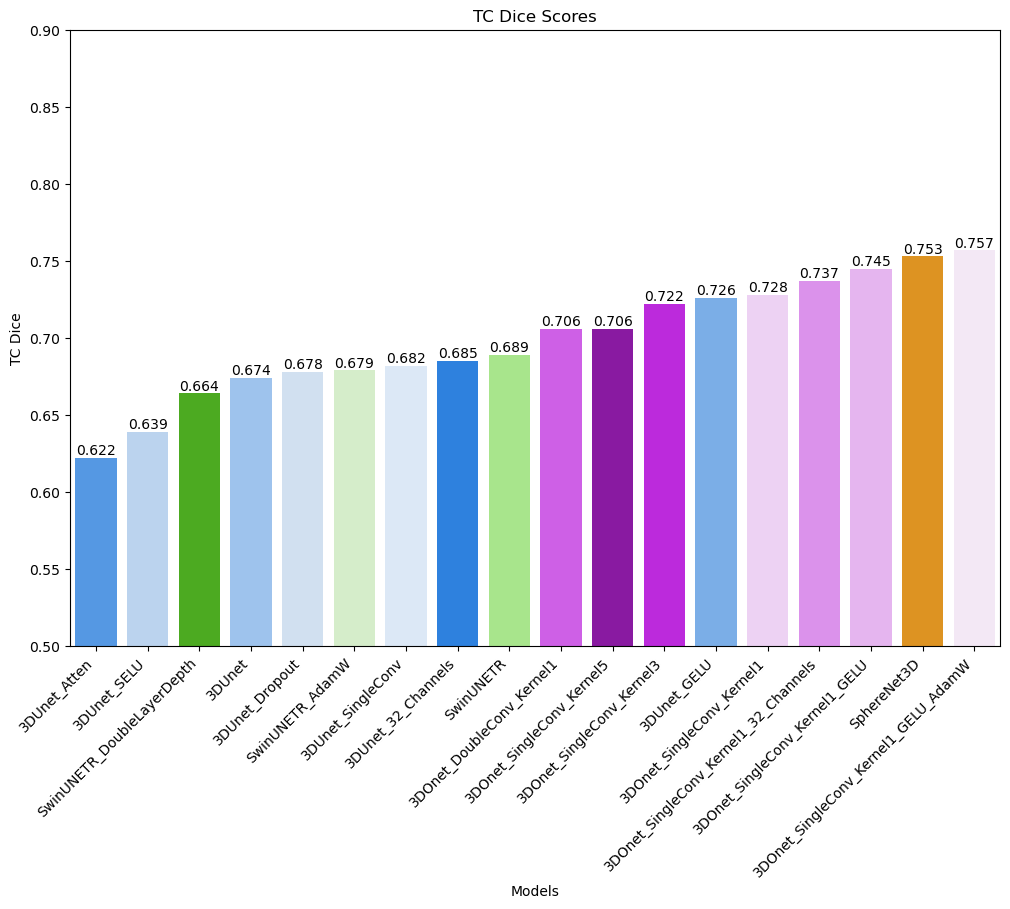

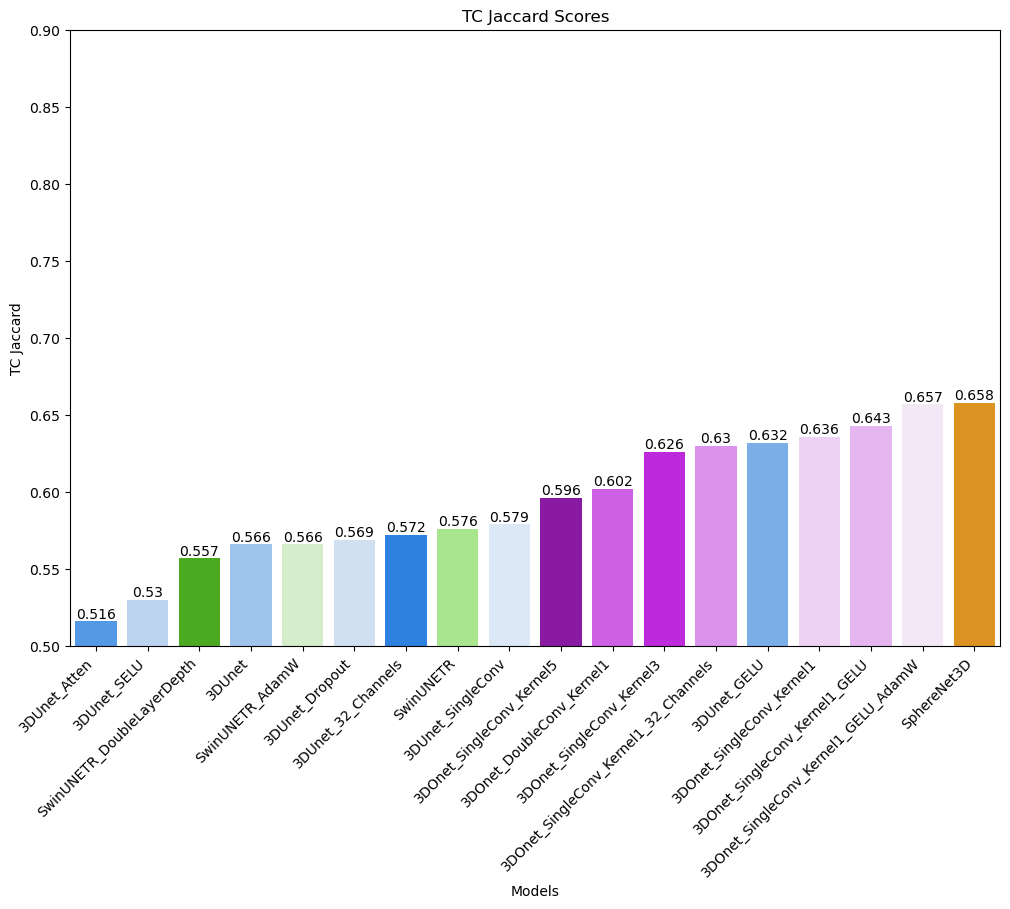

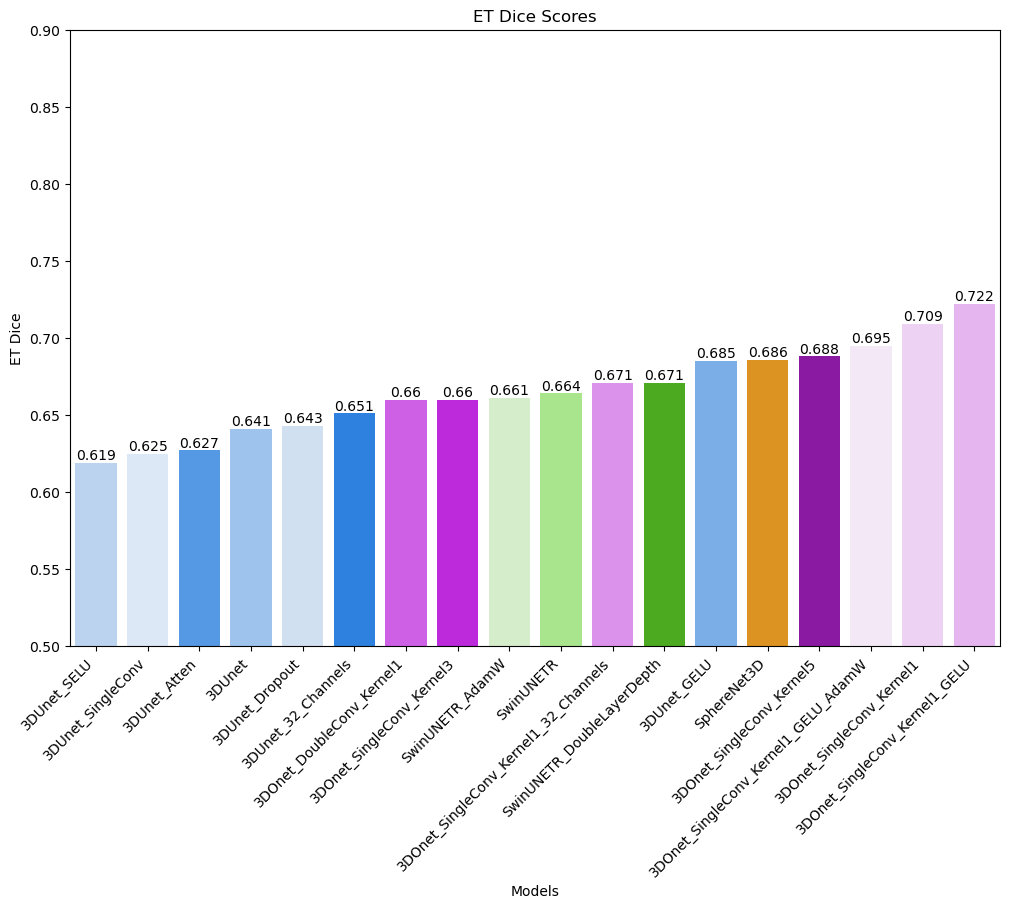

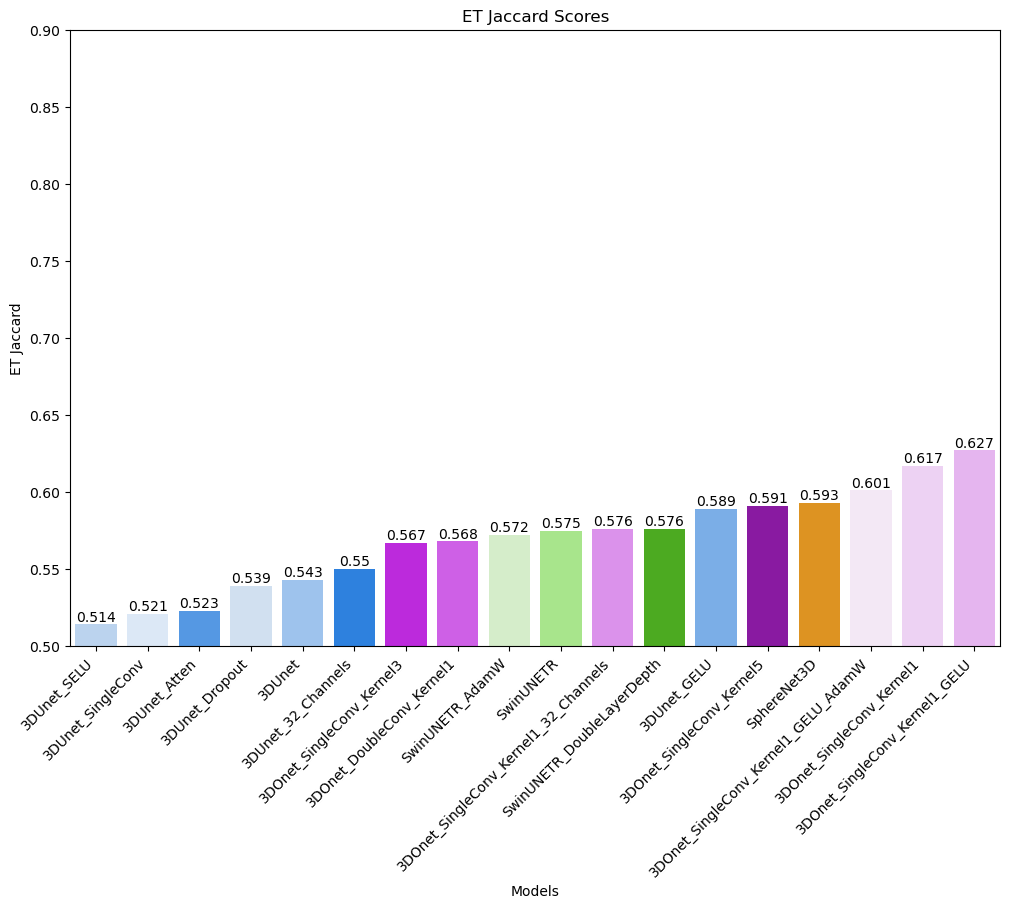

[16.355, 18.838, 18.849, 18.983, 20.287, 20.77, 21.374, 21.839, 23.384, 23.726, 23.777, 24.342, 24.915, 26.704, 28.323, 31.139, 34.315, 38.619]
2023-03-26 15:03:29,638 - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


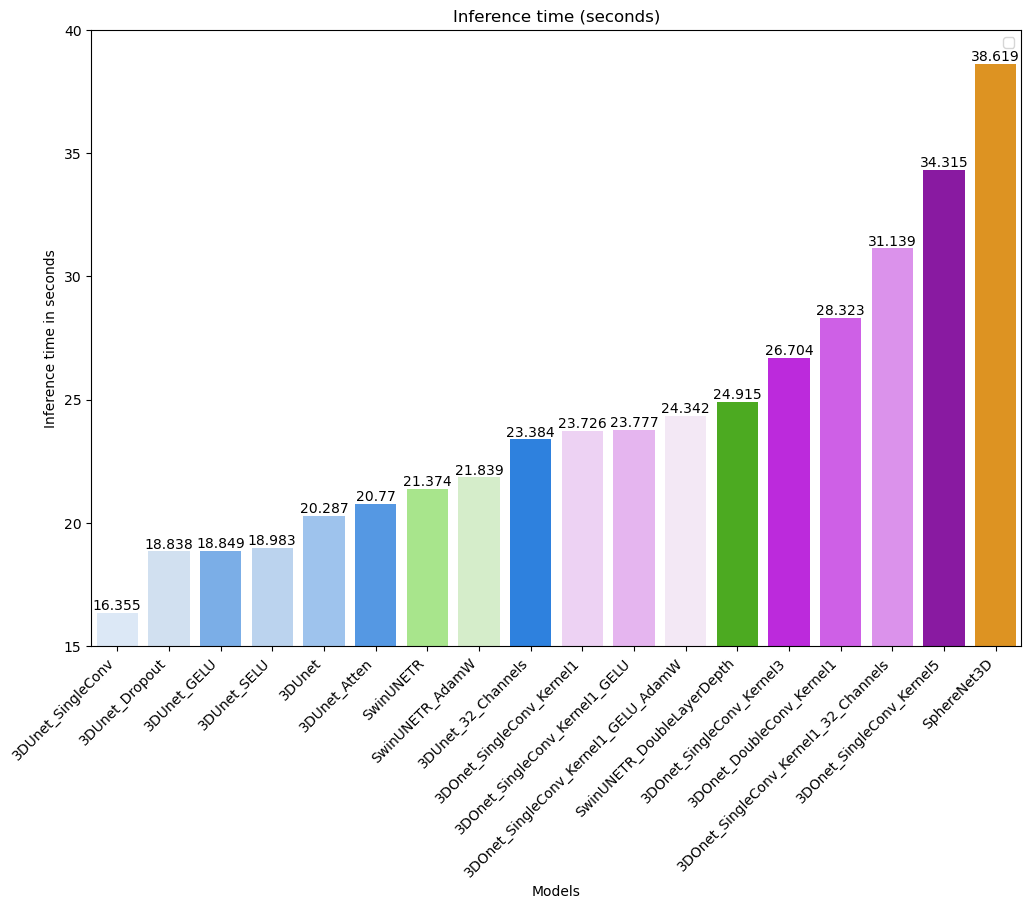

2023-03-26 15:03:29,815 - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


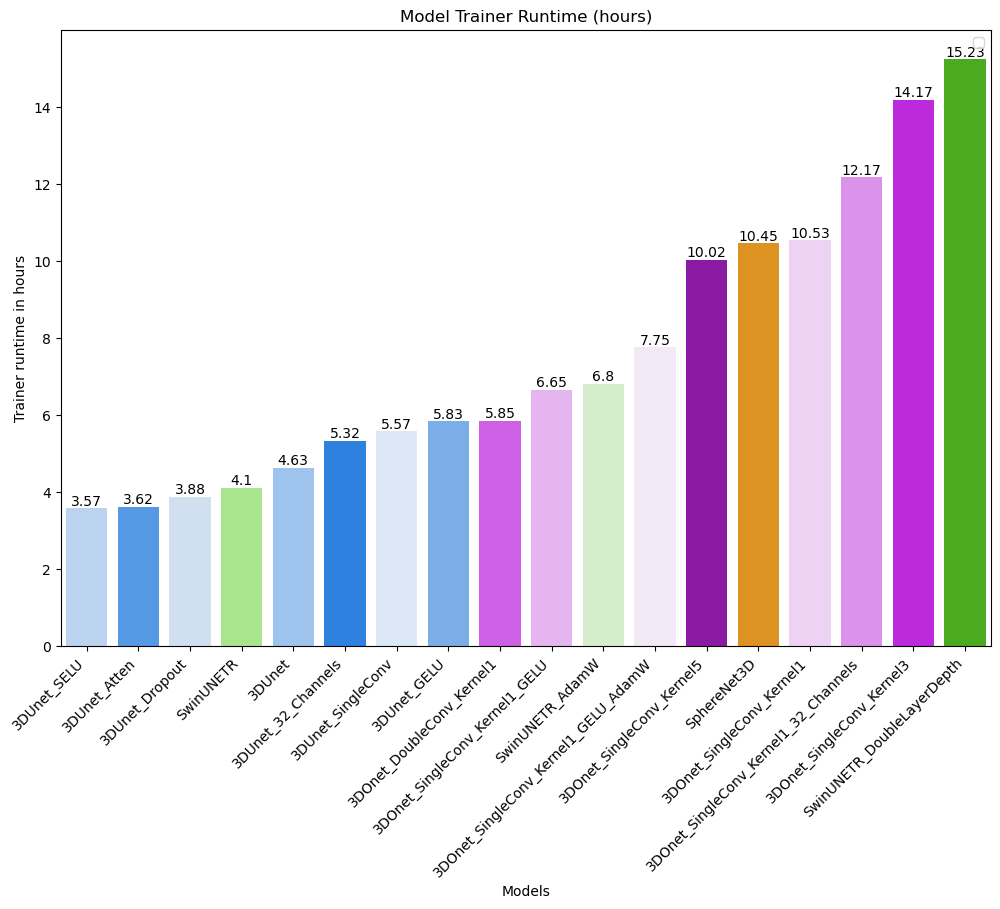

In [304]:

def plot_WT_dice():
  mean_scores_dict = {
      k: results_dict_last_epoch[k]["WT dice"] for k in results_dict_last_epoch}
  x = []
  y = []
  for model_name in mean_scores_dict:
    x.append(model_name)
    y.append(round(mean_scores_dict[model_name],3))
  x = [val for _, val in sorted(zip(y, x))]
  y = sorted(y)
  fig, ax = plt.subplots(figsize=(12, 8))
  ax.set_title("WT Dice Scores")
  # plt.bar(x, y)

  sns.barplot(x=x, y=y, palette=cols)
  ax.bar_label(ax.containers[0])
  ax.bar_label(ax.containers[0])

  ax.set_xlabel("Models")
  ax.set_ylabel("WT Dice")
  ax.set_ylim(0.5, 0.9)
  plt.xticks(rotation=45, ha='right')
  fig.savefig("results/WT_dice_all.png")
  plt.show()
  

def plot_WT_jaccard():
  mean_scores_dict = {
      k: results_dict_last_epoch[k]["WT jaccard"] for k in results_dict_last_epoch}
  x = []
  y = []
  for model_name in mean_scores_dict:
    x.append(model_name)
    y.append(round(mean_scores_dict[model_name],3))
  x = [val for _, val in sorted(zip(y, x))]
  y = sorted(y)
  fig, ax = plt.subplots(figsize=(12, 8))
  ax.set_title("WT Jaccard Scores")
  # plt.bar(x, y)

  sns.barplot(x=x, y=y, palette=cols)
  ax.bar_label(ax.containers[0])

  ax.set_xlabel("Models")
  ax.set_ylabel("WT Jaccard")
  ax.set_ylim(0.5, 0.9)
  plt.xticks(rotation=45, ha='right')
  fig.savefig("results/WT_jaccard_all.png")
  plt.show()
  

def plot_TC_dice():
  mean_scores_dict = {
      k: results_dict_last_epoch[k]["TC dice"] for k in results_dict_last_epoch}
  x = []
  y = []
  for model_name in mean_scores_dict:
    x.append(model_name)
    y.append(round(mean_scores_dict[model_name],3))
  x = [val for _, val in sorted(zip(y, x))]
  y = sorted(y)
  fig, ax = plt.subplots(figsize=(12, 8))
  ax.set_title("TC Dice Scores")
  # plt.bar(x, y)

  sns.barplot(x=x, y=y, palette=cols)
  ax.bar_label(ax.containers[0])

  ax.set_xlabel("Models")
  ax.set_ylabel("TC Dice")
  ax.set_ylim(0.5, 0.9)
  plt.xticks(rotation=45, ha='right')
  fig.savefig("results/TC_dice_all.png")
  plt.show()
  

def plot_TC_jaccard():
  mean_scores_dict = {
      k: results_dict_last_epoch[k]["TC jaccard"] for k in results_dict_last_epoch}
  x = []
  y = []
  for model_name in mean_scores_dict:
    x.append(model_name)
    y.append(round(mean_scores_dict[model_name],3))
  x = [val for _, val in sorted(zip(y, x))]
  y = sorted(y)
  fig, ax = plt.subplots(figsize=(12, 8))
  ax.set_title("TC Jaccard Scores")
  # plt.bar(x, y)

  sns.barplot(x=x, y=y, palette=cols)
  ax.bar_label(ax.containers[0])

  ax.set_xlabel("Models")
  ax.set_ylabel("TC Jaccard")
  ax.set_ylim(0.5, 0.9)
  plt.xticks(rotation=45, ha='right')
  fig.savefig("results/TC_jaccard_all.png")
  plt.show()


def plot_ET_dice():
  mean_scores_dict = {
      k: results_dict_last_epoch[k]["ET dice"] for k in results_dict_last_epoch}
  x = []
  y = []
  for model_name in mean_scores_dict:
    x.append(model_name)
    y.append(round(mean_scores_dict[model_name],3))
  x = [val for _, val in sorted(zip(y, x))]
  y = sorted(y)
  fig, ax = plt.subplots(figsize=(12, 8))
  ax.set_title("ET Dice Scores")
  # plt.bar(x, y)

  sns.barplot(x=x, y=y, palette=cols)
  ax.bar_label(ax.containers[0])

  ax.set_xlabel("Models")
  ax.set_ylabel("ET Dice")
  ax.set_ylim(0.5, 0.9)
  plt.xticks(rotation=45, ha='right')
  fig.savefig("results/ET_dice_all.png")
  plt.show()
  

def plot_ET_jaccard():
  mean_scores_dict = {
      k: results_dict_last_epoch[k]["ET jaccard"] for k in results_dict_last_epoch}
  x = []
  y = []
  for model_name in mean_scores_dict:
    x.append(model_name)
    y.append(round(mean_scores_dict[model_name],3))
  x = [val for _, val in sorted(zip(y, x))]
  y = sorted(y)
  fig, ax = plt.subplots(figsize=(12, 8))
  ax.set_title("ET Jaccard Scores")
  # plt.bar(x, y)

  sns.barplot(x=x, y=y, palette=cols)
  ax.bar_label(ax.containers[0])

  ax.set_xlabel("Models")
  ax.set_ylabel("ET Jaccard")
  ax.set_ylim(0.5, 0.9)
  plt.xticks(rotation=45, ha='right')
  fig.savefig("results/ET_jaccard_all.png")
  plt.show()


def plot_inference_time():
    inferenceDict = {
        k: results_dict_last_epoch[k]["Inference time"] for k in results_dict_last_epoch}
    # print(inferenceDict)
    x = []
    y = []
    for model_name in inferenceDict:
        x.append(model_name)
        y.append(inferenceDict[model_name])

    # sort based on ascending order of parameter count
    x = [val for _, val in sorted(zip(y, x))]
    y = sorted(y)
    y = [round(i.seconds + i.microseconds*1e-6, 3) for i in y]
    # today = datetime.datetime.now()
    # y = [datetime.datetime.combine(today, t) for t in y]
    print(y)
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_title("Inference time (seconds)")

    sns.barplot(x=x, y=y, palette=cols)
    ax.bar_label(ax.containers[0])
    ax.set_xlabel("Models")
    ax.set_ylabel("Inference time in seconds")
    ax.legend()
    ax.set_ylim(15, 40)
    plt.xticks(rotation=45, ha='right')
    fig.savefig("results/inference_time_all.png")
    plt.show()


def plot_trainer_runtime(results_dict=results_dict):
  x = []
  y = []
  for model_name in results_dict:
    x.append(model_name)
    y.append(results_dict[model_name]["trainer_runtime"])

  # sort based on ascending order of parameter count
  x = [val for _, val in sorted(zip(y, x))]
  y = sorted(y)
  y = [round(i.hour+(i.minute/60), 2) for i in y]
  # today = datetime.datetime.now()
  # y = [datetime.datetime.combine(today, t) for t in y]
  fig, ax = plt.subplots(figsize=(12, 8))
  ax.set_title("Model Trainer Runtime (hours)")

  sns.barplot(x=x, y=y, palette=cols)
  ax.bar_label(ax.containers[0])
  # plt.bar(x, y)
  ax.set_xlabel("Models")
  ax.set_ylabel("Trainer runtime in hours")
  ax.legend()
  plt.xticks(rotation=45, ha='right')
  fig.savefig("results/trainer_runtime_all.png")
  plt.show()


plot_WT_dice()
plot_WT_jaccard()
plot_TC_dice()
plot_TC_jaccard()
plot_ET_dice()
plot_ET_jaccard()
plot_inference_time()
plot_trainer_runtime()


In [119]:
results_dict_last_epoch["3DOnet_DoubleConv_Kernel1"]['val_metics_df']
for k in results_dict_last_epoch:
  results_dict_last_epoch[k]['val_metics_df'] = results_dict_last_epoch[k]['val_metics_df'].to_dict()


3DOnet_SingleConv_Kernel1_32_Channels
SphereNet3D
3DUnet_SingleConv
3DOnet_SingleConv_Kernel1_GELU_AdamW
SwinUNETR_AdamW
3DUnet_Atten
3DOnet_SingleConv_Kernel1
SwinUNETR
3DOnet_DoubleConv_Kernel1
3DUnet_Dropout
3DUnet_SELU
3DUnet
3DUnet_32_Channels
3DOnet_SingleConv_Kernel1_GELU
SwinUNETR_DoubleLayerDepth
3DUnet_GELU
3DOnet_SingleConv_Kernel5
3DOnet_SingleConv_Kernel3


In [237]:

x = []
y = []
for k in results_dict:
  x.append(k)
  y.append(results_dict[k]["parameter_count"])
  # parameter_count_df.loc[k] = results_dict[k]["parameter_count"]
data_tuple = list(zip(x, y))
parameter_count_df = pd.DataFrame(
    data_tuple, columns=['Model', 'Params (1e6)']).set_index("Model")
parameter_count_df = parameter_count_df.applymap(lambda x: round(x*1e-6,2))
parameter_count_df


,Params (1e6)
Model,
3DOnet_SingleConv_Kernel1_32_Channels,5.60
SphereNet3D,6.13
3DUnet_SingleConv,3.01
3DOnet_SingleConv_Kernel1_GELU_AdamW,3.15
SwinUNETR_AdamW,14.98
3DUnet_Atten,6.09
3DOnet_SingleConv_Kernel1,3.15
SwinUNETR,14.98
3DOnet_DoubleConv_Kernel1,5.90


In [238]:

x = []
y = []
for k in results_dict:
  x.append(k)
  y.append(results_dict[k]["trainer_runtime"])
  # parameter_count_df.loc[k] = results_dict[k]["parameter_count"]
y = [round(i.hour+(i.minute/60),3) for i in y]
data_tuple = list(zip(x, y))
trainer_runtime_df = pd.DataFrame(
    data_tuple, columns=['Model', 'Train time (h)']).set_index("Model")
# trainer_runtime_df = trainer_runtime_df.applymap(lambda x: round(x*1e-6, 2))
trainer_runtime_df


,Train time (h)
Model,
3DOnet_SingleConv_Kernel1_32_Channels,12.167
SphereNet3D,10.450
3DUnet_SingleConv,5.567
3DOnet_SingleConv_Kernel1_GELU_AdamW,7.750
SwinUNETR_AdamW,6.800
3DUnet_Atten,3.617
3DOnet_SingleConv_Kernel1,10.533
SwinUNETR,4.100
3DOnet_DoubleConv_Kernel1,5.850


In [302]:
results_df = pd.DataFrame()
# for k in results_dict_last_epoch:
results_df = pd.DataFrame.from_dict(results_dict_last_epoch)
results_df = results_df.transpose().sort_index()
results_rounded = results_df
results_rounded["Inference time"] = results_rounded["Inference time"].apply(
    lambda x: float(np.format_float_positional(x.seconds + x.microseconds*1e-6, precision=4, unique=False, fractional=False, trim='k')))
# results_df.applymap('{:,.2f}'.format)
# results_rounded
results_rounded = results_rounded.applymap(lambda x: float(
    np.format_float_positional(x, precision=4, unique=False, fractional=False, trim='k')))

results_rounded = results_rounded.join(trainer_runtime_df)
results_rounded = results_rounded.join(parameter_count_df)

results_rounded.rename(
    columns={'Inference time': 'Infer time (s)'}, inplace=True)
results_rounded.to_csv("results/full_results_statistics.csv")
results_rounded


,WT dice,WT jaccard,TC dice,TC jaccard,ET dice,ET jaccard,Infer time (s),Train time (h),Params (1e6)
3DOnet_DoubleConv_Kernel1,0.8801,0.8022,0.7058,0.6017,0.6600,0.5678,28.32,5.850,5.90
3DOnet_SingleConv_Kernel1,0.8753,0.7956,0.7282,0.6363,0.7093,0.6172,23.73,10.533,3.15
3DOnet_SingleConv_Kernel1_32_Channels,0.8860,0.8085,0.7365,0.6300,0.6706,0.5761,31.14,12.167,5.60
3DOnet_SingleConv_Kernel1_GELU,0.8817,0.8050,0.7449,0.6435,0.7218,0.6266,23.78,6.650,3.15
3DOnet_SingleConv_Kernel1_GELU_AdamW,0.8879,0.8097,0.7572,0.6565,0.6948,0.6006,24.34,7.750,3.15
3DOnet_SingleConv_Kernel3,0.8593,0.7797,0.7217,0.6264,0.6597,0.5667,26.70,14.167,6.03
3DOnet_SingleConv_Kernel5,0.8705,0.7897,0.7064,0.5962,0.6877,0.5905,34.32,10.017,16.86
3DUnet,0.8750,0.7900,0.6736,0.5661,0.6414,0.5425,20.29,4.633,5.65
3DUnet_32_Channels,0.8651,0.7810,0.6849,0.5722,0.6508,0.5498,23.38,5.317,10.05
3DUnet_Atten,0.8290,0.7334,0.6216,0.5163,0.6267,0.5231,20.77,3.617,6.09


In [241]:
print(results_rounded.to_latex())


\begin{tabular}{lrrrrrrrrr}
\toprule
{} &  WT dice &  WT jaccard &  TC dice &  TC jaccard &  ET dice &  ET jaccard &  Infer time (s) &  Train time (h) &  Params (1e6) \\
\midrule
3DOnet\_DoubleConv\_Kernel1             &   0.8801 &      0.8022 &   0.7058 &      0.6017 &   0.6600 &      0.5678 &           28.32 &           5.850 &          5.90 \\
3DOnet\_SingleConv\_Kernel1             &   0.8753 &      0.7956 &   0.7282 &      0.6363 &   0.7093 &      0.6172 &           23.73 &          10.533 &          3.15 \\
3DOnet\_SingleConv\_Kernel1\_32\_Channels &   0.8860 &      0.8085 &   0.7365 &      0.6300 &   0.6706 &      0.5761 &           31.14 &          12.167 &          5.60 \\
3DOnet\_SingleConv\_Kernel1\_GELU        &   0.8817 &      0.8050 &   0.7449 &      0.6435 &   0.7218 &      0.6266 &           23.78 &           6.650 &          3.15 \\
3DOnet\_SingleConv\_Kernel1\_GELU\_AdamW  &   0.8879 &      0.8097 &   0.7572 &      0.6565 &   0.6948 &      0.6006 &           24.34 &  

In [186]:
def generate_eval_csv():
    for k in results_dict_last_epoch:
        print(k)
        sample_results = pd.DataFrame.from_dict(
            results_dict_last_epoch[k]["val_metics_df"])
        sample_results.to_csv(f"Logs/{k}/eval_results.csv")
        


generate_eval_csv()

3DOnet_SingleConv_Kernel1_32_Channels
SphereNet3D
3DUnet_SingleConv
3DOnet_SingleConv_Kernel1_GELU_AdamW
SwinUNETR_AdamW
3DUnet_Atten
3DOnet_SingleConv_Kernel1
SwinUNETR
3DOnet_DoubleConv_Kernel1
3DUnet_Dropout
3DUnet_SELU
3DUnet
3DUnet_32_Channels
3DOnet_SingleConv_Kernel1_GELU
SwinUNETR_DoubleLayerDepth
3DUnet_GELU
3DOnet_SingleConv_Kernel5
3DOnet_SingleConv_Kernel3


In [264]:
def save_predictions_in_log(target="BraTS20_Training_004", treshold=0.5):
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  
  name, imgs, targets = None, None, None
  _, _, test_dataloader = get_dataloaders(
      dataset=BratsDataset, path_to_csv="./fold_data.csv", val_fold=0, test_fold=1, batch_size=1, do_resizing=True)
  
  for i, data in enumerate(test_dataloader):
    if data['Id'][0] == target:
      print("Target found: ", target)
      name, imgs, targets = data['Id'][0], data['image'], data['mask']
  
  for dirname in os.listdir("Logs"):
    model_name = dirname
    model = modelDict[model_name]
    savepath = f"Logs/{dirname}/prediction_samples"
    if not os.path.isdir(savepath):
      os.mkdir(savepath)
    results = {"Id": [], "image": [], "GT": [], "Prediction": []}

    checkpoint_path = None

    for filename in os.listdir(f"Logs/{dirname}"):
      if "your_last_epoch_model" in filename:
        checkpoint_path = f"Logs/{dirname}/{filename}"
        break

    try:
      model.load_state_dict(torch.load(checkpoint_path, map_location='cpu'))
      model.eval()
      print(f"{model_name} loaded with chkpt: {checkpoint_path}. parameters: {count_parameters(model)}")
    except Exception as e:
      print(f"Error loading {model_name} with chkpt: {checkpoint_path}. parameters: {count_parameters(model)}")
      print(e)

    with torch.no_grad():
      print("Predicting for: ", model_name)
      imgs, targets = imgs.to(device), targets.to(device)
      logits = model(imgs)
      probs = torch.sigmoid(logits)

      predictions = (probs >= treshold).float()
      predictions = predictions.cpu()
      targets = targets.cpu()
      
      img, gt, prediction = imgs.cpu(), targets, predictions
      
      img = img.squeeze()[0].cpu().detach().numpy()
      gt0 = gt[0][0].squeeze().cpu().detach().numpy()
      gt1 = gt[0][1].squeeze().cpu().detach().numpy()
      gt2 = gt[0][2].squeeze().cpu().detach().numpy()
      pred0 = prediction[0][0].squeeze().cpu().detach().numpy()
      pred1 = prediction[0][1].squeeze().cpu().detach().numpy()
      pred2 = prediction[0][2].squeeze().cpu().detach().numpy()
      
      for i in range(50, 90+1, 5):

        fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(
            1, 7, figsize=(30, 10))
        slice_w = i
        
        ax1.imshow(img[slice_w, :, :], cmap="gray")
        ax1.set_title(f'img')
        ax2.imshow(gt0[slice_w, :, :], cmap="viridis")
        ax2.set_title(f'WT_GT')
        ax3.imshow(pred0[slice_w, :, :], cmap="viridis")
        ax3.set_title(f'WT_Pred')
        ax4.imshow(gt1[slice_w, :, :], cmap="cividis")
        ax4.set_title(f'TC_GT')
        ax5.imshow(pred1[slice_w, :, :], cmap="cividis")
        ax5.set_title(f'TC_Pred')
        ax6.imshow(gt2[slice_w, :, :], cmap="plasma")
        ax6.set_title(f'ET_GT')
        ax7.imshow(pred2[slice_w, :, :], cmap="plasma")
        ax7.set_title(f'ET_Pred')
        # fig.tight_layout(rect=[0, 0.03, 1, 0.95])
        fig.suptitle(
            f'Model: {model_name} | Sample: {name} | Slice: {i}', y=0.7, fontsize=16)
        # plt.show()
        fig.savefig(f"{savepath}/prediction_{name}_slice_{i}.png",
                    format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')
        print(
            f"Saving to {savepath}/prediction_{name}_slice_{i}.png")
    del model
  

# save_predictions_in_log()

Target found:  BraTS20_Training_004
3DOnet_SingleConv_Kernel1_32_Channels loaded with chkpt: Logs/3DOnet_SingleConv_Kernel1_32_Channels/your_last_epoch_model_20230314-222549.pth. parameters: 5597571
Predicting for:  3DOnet_SingleConv_Kernel1_32_Channels
SphereNet3D loaded with chkpt: Logs/SphereNet3D/your_last_epoch_model_20230319-011358.pth. parameters: 6134019
Predicting for:  SphereNet3D
3DUnet_SingleConv loaded with chkpt: Logs/3DUnet_SingleConv/your_last_epoch_model_20230322-164951.pth. parameters: 3006507
Predicting for:  3DUnet_SingleConv
3DOnet_SingleConv_Kernel1_GELU_AdamW loaded with chkpt: Logs/3DOnet_SingleConv_Kernel1_GELU_AdamW/your_last_epoch_model_20230317-195004.pth. parameters: 3150435
Predicting for:  3DOnet_SingleConv_Kernel1_GELU_AdamW
SwinUNETR_AdamW loaded with chkpt: Logs/SwinUNETR_AdamW/your_last_epoch_model_20230311-072307.pth. parameters: 14981601
Predicting for:  SwinUNETR_AdamW
3DUnet_Atten loaded with chkpt: Logs/3DUnet_Atten/your_last_epoch_model_20230311

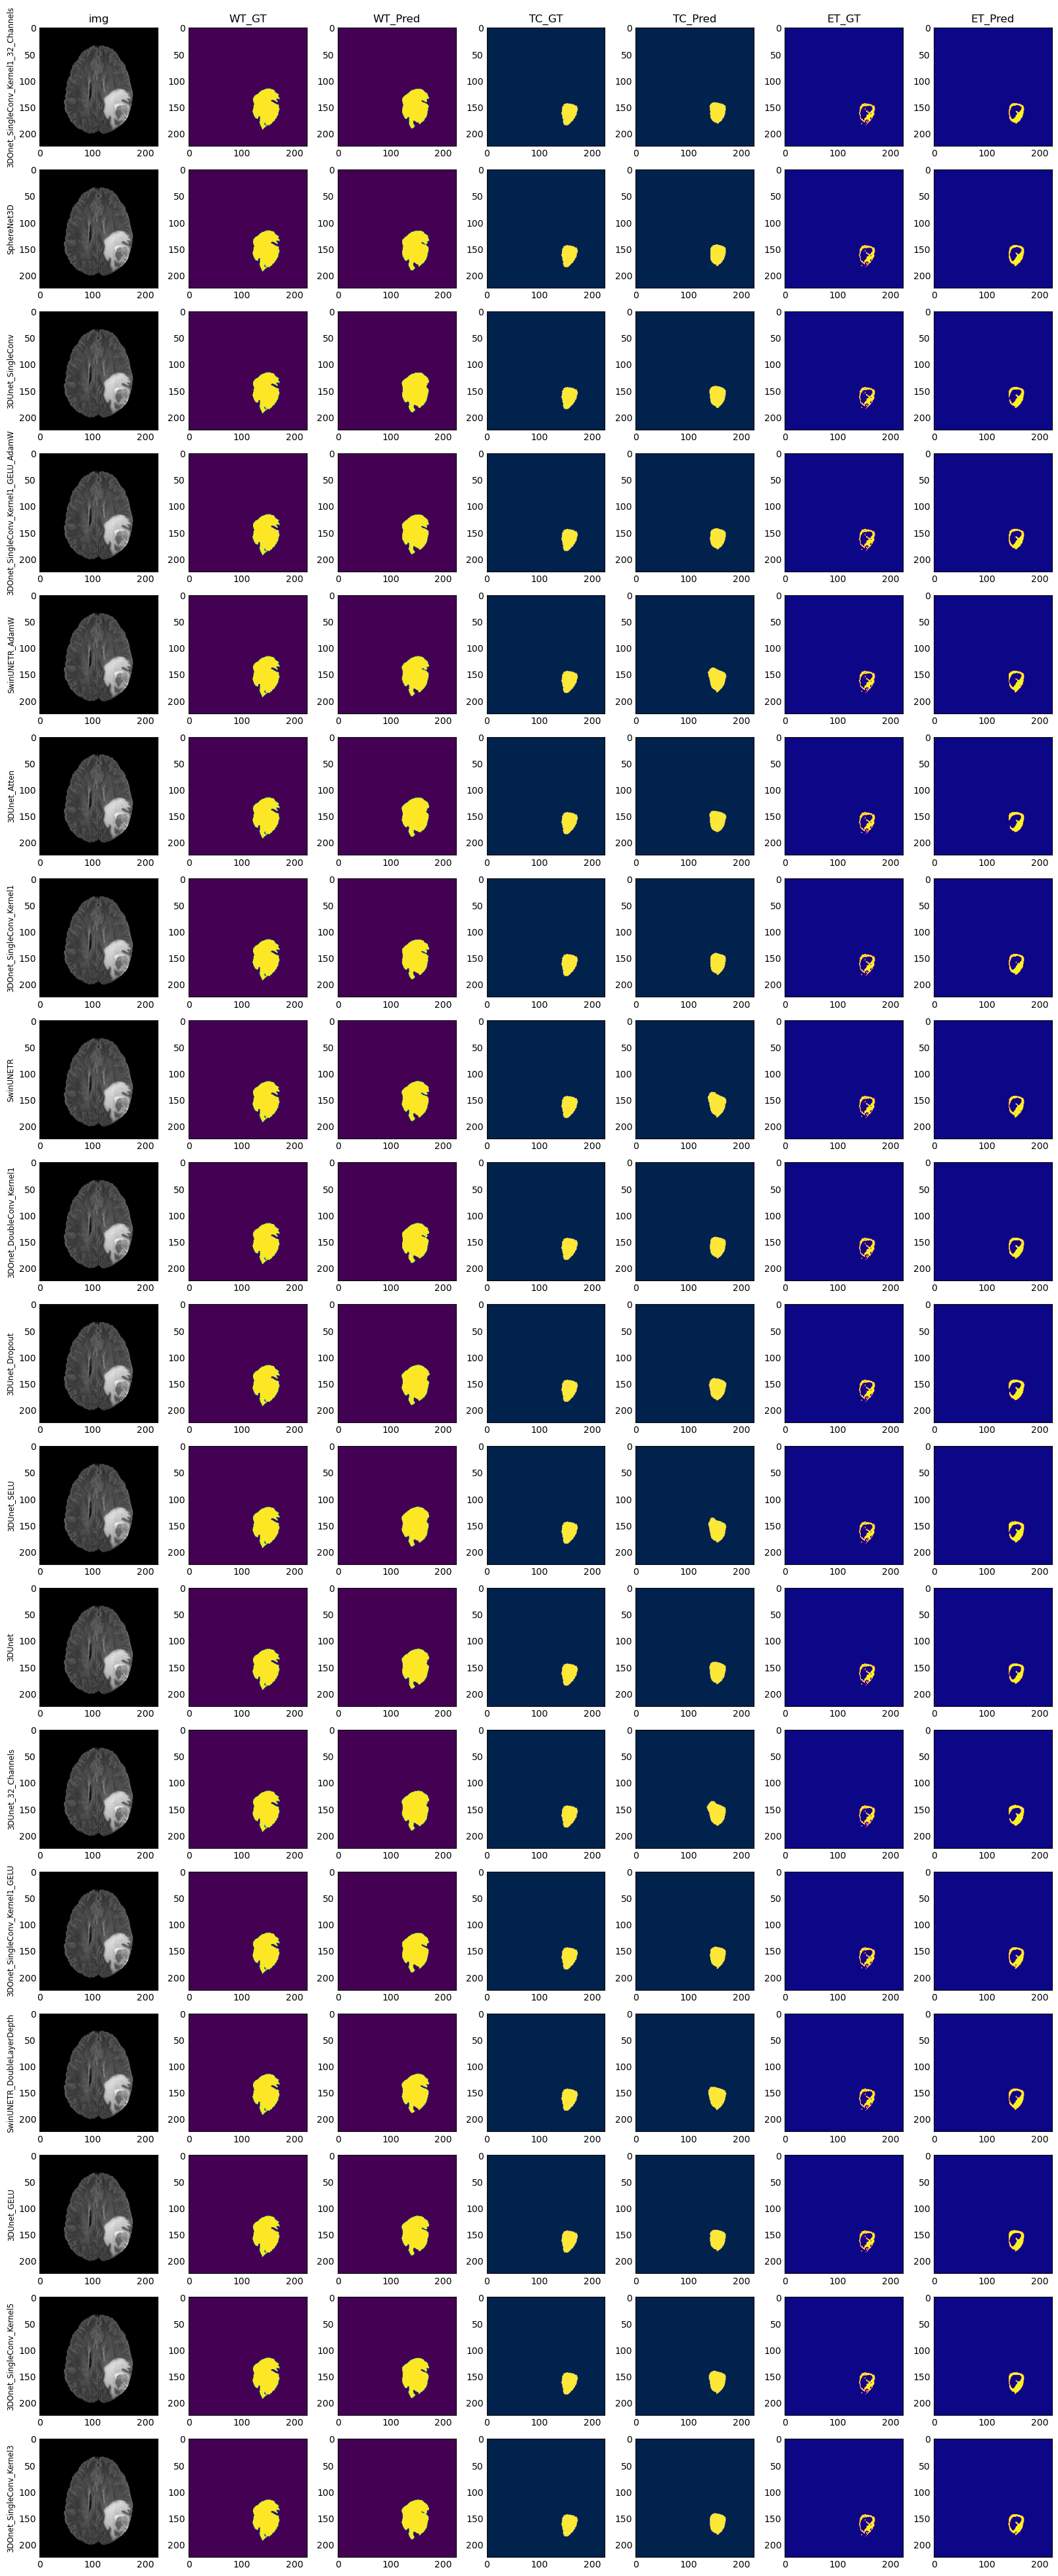

In [280]:
def compare_predictions_in_results(target="BraTS20_Training_004", treshold=0.5):
  device = 'cuda' if torch.cuda.is_available() else 'cpu'

  name, imgs, targets = None, None, None
  _, _, test_dataloader = get_dataloaders(
      dataset=BratsDataset, path_to_csv="./fold_data.csv", val_fold=0, test_fold=1, batch_size=1, do_resizing=True)

  for i, data in enumerate(test_dataloader):
    if data['Id'][0] == target:
      print("Target found: ", target)
      name, imgs, targets = data['Id'][0], data['image'], data['mask']
      
  fig, ax_array = plt.subplots(len(os.listdir("Logs")), 7, figsize=(20, 50))
  
  rows = []
  cols = ['img', 'WT_GT', 'WT_Pred', 'TC_GT', 'TC_Pred', 'ET_GT', 'ET_Pred']
  for i, dirname in enumerate(os.listdir("Logs")):
    
    model_name = dirname
    rows.append(model_name)
    model = modelDict[model_name]
    checkpoint_path = None

    for filename in os.listdir(f"Logs/{dirname}"):
      if "your_last_epoch_model" in filename:
        checkpoint_path = f"Logs/{dirname}/{filename}"
        break

    try:
      model.load_state_dict(torch.load(checkpoint_path, map_location='cpu'))
      model.eval()
      print(f"{model_name} loaded with chkpt: {checkpoint_path}. parameters: {count_parameters(model)}")
    except Exception as e:
      print(
          f"Error loading {model_name} with chkpt: {checkpoint_path}. parameters: {count_parameters(model)}")
      print(e)

    with torch.no_grad():
      print("Predicting for: ", model_name)
      imgs, targets = imgs.to(device), targets.to(device)
      logits = model(imgs)
      probs = torch.sigmoid(logits)

      predictions = (probs >= treshold).float()
      predictions = predictions.cpu()
      targets = targets.cpu()

      img, gt, prediction = imgs.cpu(), targets, predictions

      img = img.squeeze()[0].cpu().detach().numpy()
      gt0 = gt[0][0].squeeze().cpu().detach().numpy()
      gt1 = gt[0][1].squeeze().cpu().detach().numpy()
      gt2 = gt[0][2].squeeze().cpu().detach().numpy()
      pred0 = prediction[0][0].squeeze().cpu().detach().numpy()
      pred1 = prediction[0][1].squeeze().cpu().detach().numpy()
      pred2 = prediction[0][2].squeeze().cpu().detach().numpy()

      
      slice_w = 75
      
      ax_array[i][0].imshow(img[slice_w, :, :], cmap="gray")
      ax_array[i][0].tick_params(axis='both', length=0, width=0)
      ax_array[i][0].set_xlabel('')
      ax_array[i][0].set_ylabel('')
      ax_array[i][1].imshow(gt0[slice_w, :, :], cmap="viridis")
      ax_array[i][1].tick_params(axis='both', length=0, width=0)
      ax_array[i][1].set_xlabel('')
      ax_array[i][1].set_ylabel('')
      ax_array[i][2].imshow(pred0[slice_w, :, :], cmap="viridis")
      ax_array[i][2].tick_params(axis='both', length=0, width=0)
      ax_array[i][2].set_xlabel('')
      ax_array[i][2].set_ylabel('')
      ax_array[i][3].imshow(gt1[slice_w, :, :], cmap="cividis")
      ax_array[i][3].tick_params(axis='both', length=0, width=0)
      ax_array[i][3].set_xlabel('')
      ax_array[i][3].set_ylabel('')
      ax_array[i][4].imshow(pred1[slice_w, :, :], cmap="cividis")
      ax_array[i][4].tick_params(axis='both', length=0, width=0)
      ax_array[i][4].set_xlabel('')
      ax_array[i][4].set_ylabel('')
      ax_array[i][5].imshow(gt2[slice_w, :, :], cmap="plasma")
      ax_array[i][5].tick_params(axis='both', length=0, width=0)
      ax_array[i][5].set_xlabel('')
      ax_array[i][5].set_ylabel('')
      ax_array[i][6].imshow(pred2[slice_w, :, :], cmap="plasma")
      ax_array[i][6].tick_params(axis='both', length=0, width=0)
      ax_array[i][6].set_xlabel('')
      ax_array[i][6].set_ylabel('')

    del model
  for ax, col in zip(ax_array[0], cols):
    ax.set_title(col)
  for ax, row in zip(ax_array[:, 0], rows):
    ax.set_ylabel(row, rotation=90, size='small')
  fig.savefig(f"results/prediction_comparison.png",
              format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')
  print(
      f"Saving to results/prediction_comparison.png")
  plt.show()
  # fig.suptitle(f'Model: {model_name} | Sample: {name} | Slice: {slice_w}', y=0.7, fontsize=16)


# compare_predictions_in_results()
